#### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns

import random
import datetime as dt

### Exploratory data analysis

In [3]:
# Read data set 

df = pd.read_excel("Data/Online_Retail.xlsx")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

# The data set contains of 541.909 rows and 8 columns
# For attribute description, see the readme in my repository 
# Keep all the columns as they all contain necessary data. Moreover, later we gonna add some columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.dtypes

# All data types look good. There is no category data type. Later I might seperate the time from the date, in order to analyse the customer shopping behaviour

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
df.nunique()

print("There are " + str(df.InvoiceNo.nunique()) + " unique orders.")
print("There are " + str(df.StockCode.nunique()) + " unique products.")
print("There are " + str(df.CustomerID.nunique()) + " unique customers.")
print("The customers are from " + str(df.Country.nunique()) + " different countries.")

There are 25900 unique orders.
There are 4070 unique products.
There are 4372 unique customers.
The customers are from 38 different countries.


In [8]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [9]:
df.InvoiceNo.value_counts(dropna=False)

# There is an invoice number which appears 1114 times. This means, one purchase contains 1114 articles 

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554023        1
554022        1
554021        1
554020        1
C558901       1
Name: InvoiceNo, Length: 25900, dtype: int64

In [10]:
df.StockCode.value_counts(dropna=False)

# A product that has been sold 2313 times 

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [11]:
df.CustomerID.value_counts(dropna=False)

# 135.080 rows with missing customerIDs. That´s a lot! (might drop them later)

NaN        135080
17841.0      7983
14911.0      5903
14096.0      5128
12748.0      4642
            ...  
13270.0         1
17763.0         1
17291.0         1
15668.0         1
15562.0         1
Name: CustomerID, Length: 4373, dtype: int64

In [12]:
df.describe()

# There are negative unit prices and quantity (in case of cancellation). To be removed
# There are ouliters in quantity and unit price that have to be removed

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
df['Description'].value_counts().head()

# Which items were sold most often

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

### Data cleaning 

##### Null Values Handling

In [14]:
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [15]:
# drop null values in customer id and description.(nulls in description also have no customer and price, so not needed) We can´t work with null-customers 

df.CustomerID.isnull().values.sum()

135080

In [16]:
df.Description.isnull().values.sum()

1454

In [17]:
df_clean = df.dropna()

In [18]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
df_clean.isna().sum()

# Check if there are missing values in the new dataframe

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

##### Duplicates Removing

In [20]:
df_clean[df_clean.duplicated()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


In [21]:
df_clean.duplicated().sum()

# In the whole df_clean there are 5225 duplicates. These will be dropped.

5225

In [22]:
df_clean.drop_duplicates(inplace=True)

C:\Users\admin\anaconda3\envs\DA_env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [23]:
df_clean.duplicated().sum()

0

In [24]:
df_clean.shape

# After dropping dublicates and null values the data set has about 100.000 less rows. Now it´s 401.604

(401604, 8)

##### Negative Values Handling

In [25]:
(df_clean["Quantity"] <= 0).sum()

# There are 8872 transactions with a negative quantity of items. These might be cancellations. Eventhough it would be interesting to analyse the cancellations, for now we drop them

8872

In [26]:
df_clean.loc[df_clean["Quantity"] < 0].count()

InvoiceNo      8872
StockCode      8872
Description    8872
Quantity       8872
InvoiceDate    8872
UnitPrice      8872
CustomerID     8872
Country        8872
dtype: int64

In [27]:
df_clean = df_clean[df_clean["Quantity"] > 0]

In [28]:
df_clean.shape

(392732, 8)

In [29]:
(df_clean["UnitPrice"] <= 0).sum()

# There are 40 transactions where the price per unit is equal/belove 0. These might be mistakes, or maybe free items? E.g. from marketing actions like "buy 2, get 3" or similar. We don´t need them

40

In [30]:
df_clean = df_clean[df_clean["UnitPrice"] > 0]

In [31]:
df_clean.shape

(392692, 8)

In [32]:
# Dropping invoices for cancellations(starting with "C") might be an additional step, to be sure. 
# df_clean[df_clean["InvoiceNo"].str.startswith("C")] - how to read them
# But with the removing of negative quantity values, the cancellations for sure have all been removed (and with that also other mistaken quantity rows)

##### Data Type Changing

In [33]:
df_clean = df_clean.astype({"CustomerID":"int"})

# Change data type of CustomerID from float to integer

In [34]:
df_clean.CustomerID.dtypes

dtype('int32')

#####  Outliers Removing

In [35]:
df_clean.describe()

# Negative values in unit price and quantity have been removed, but also the positive outliers need to be removed in order for the following modelling

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [36]:
df_clean.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,CustomerID
0.050,1.0,0.42,12626.0
0.950,36.0,8.50,17905.0
0.980,96.0,12.75,18119.0
0.990,120.0,14.95,18211.0
0.999,504.0,49.95,18283.0


Text(0.5, 1.0, 'Quantity and Price Outliers')

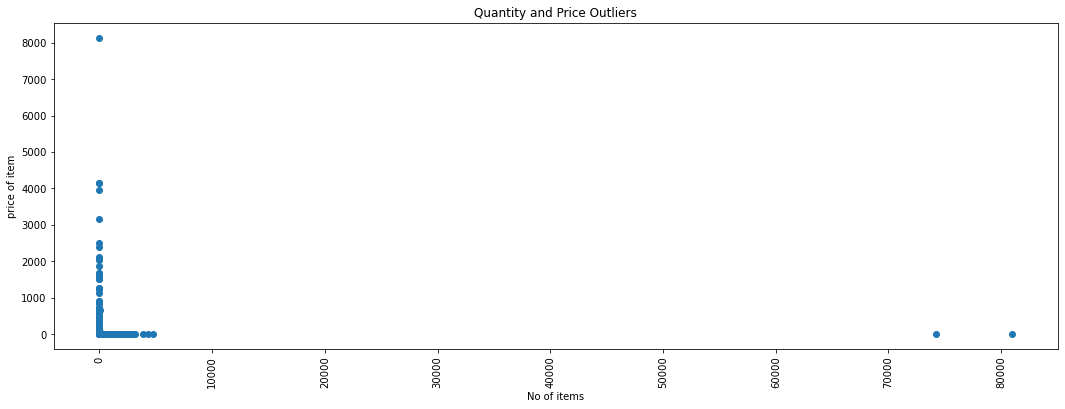

In [37]:
plt.figure(figsize = (18,6))
plt.scatter(data = df_clean, x = "Quantity", y = "UnitPrice")
plt.xticks(rotation = 90)
plt.xlabel("No of items")
plt.ylabel("price of item")
plt.title("Quantity and Price Outliers")

Text(0.5, 1.0, 'Quantity and Price Outliers')

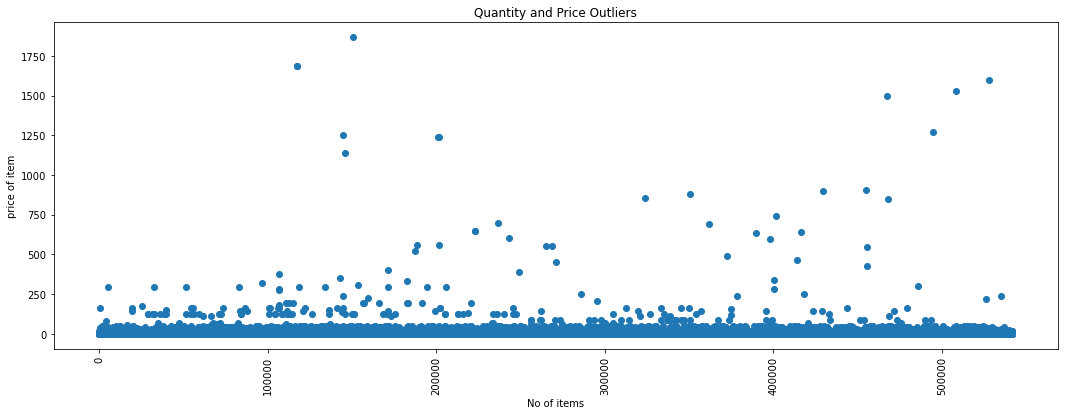

In [53]:
df_clean = df_clean[df_clean["Quantity"] < 1000]
plt.figure(figsize = (18,6))
plt.scatter(x = df_clean.index, y = df_clean["UnitPrice"])
plt.xticks(rotation = 90)
plt.xlabel("No of items")
plt.ylabel("price of item")
plt.title("Quantity and Price Outliers")

# Drop quantity outliers above 1000

Text(0.5, 1.0, 'Quantity and Price Outliers')

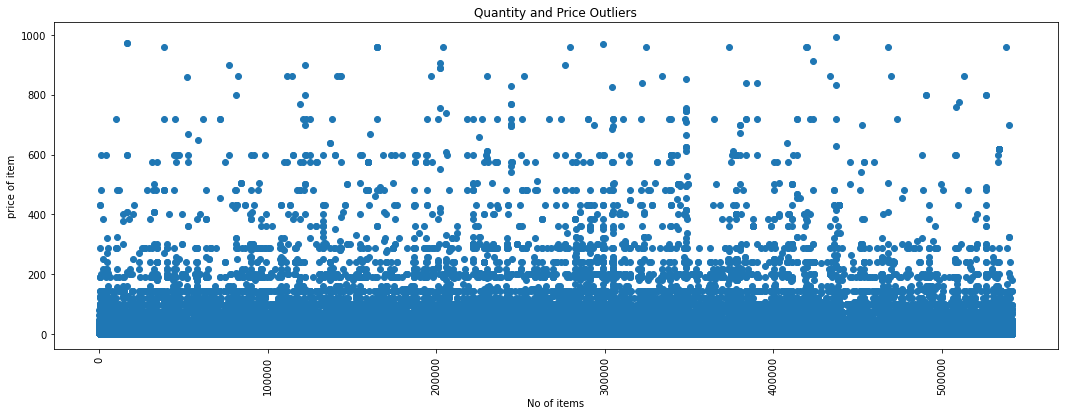

In [54]:
df_clean = df_clean[df_clean['UnitPrice'] < 300]
plt.figure(figsize=(18,6))
plt.scatter(x=df_clean.index, y=df_clean['Quantity'])
plt.xticks(rotation=90)
plt.xlabel("No of items")
plt.ylabel("price of item")
plt.title("Quantity and Price Outliers")

# Drop unit price outliers above 2000

Text(0.5, 1.0, 'Quantity and Price Outliers')

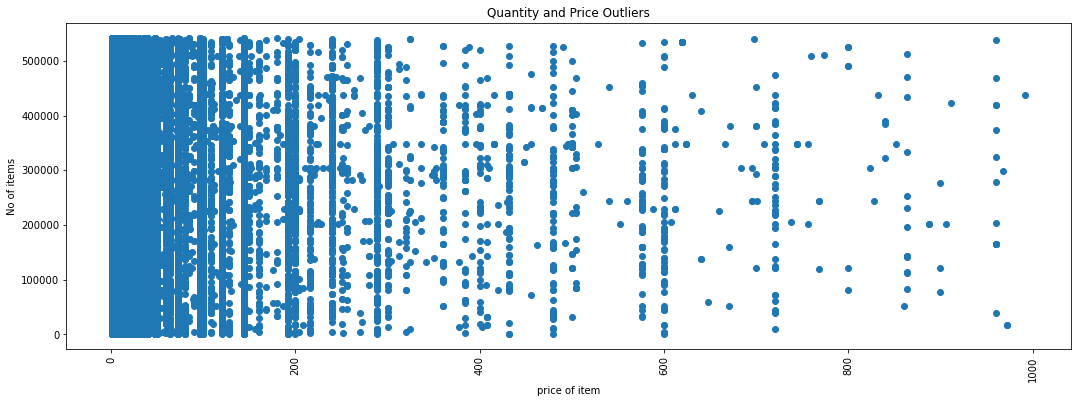

In [56]:
df_clean = df_clean[df_clean['UnitPrice'] < 300]
plt.figure(figsize=(18,6))
plt.scatter(y=df_clean.index, x=df_clean['Quantity'])
plt.xticks(rotation=90)
plt.ylabel("No of items")
plt.xlabel("price of item")
plt.title("Quantity and Price Outliers")

# Drop unit price outliers above 300

In [57]:
df_clean.describe()

# This was a conservative dropping of outliers. Check if keep unit price only until 500 instead

,Quantity,UnitPrice,TotalAmount,CustomerID
count,392524.000000,392524.000000,392524.000000,392524.000000
mean,12.272564,2.950675,21.325146,15287.907705
std,31.576436,4.531552,61.739140,1713.466986
min,1.000000,0.001000,0.001000,12347.000000
25%,2.000000,1.250000,4.950000,13955.000000
50%,6.000000,1.950000,12.300000,15150.000000
75%,12.000000,3.750000,19.800000,16791.000000
max,992.000000,295.000000,4522.500000,18287.000000


In [58]:
df_clean.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,TotalAmount,CustomerID
0.050,1.0,0.42,1.250,12626.0
0.950,36.0,8.50,67.500,17905.0
0.980,96.0,12.75,135.000,18119.0
0.990,120.0,14.95,199.200,18211.0
0.999,480.0,40.00,764.477,18283.0


#### Feature Engineering

In [41]:
# The data set contains information for the amount of items per purchase(invoice) and the price per unit. 
# Add a column with the whole value of a purchase "TotalAmount"

In [42]:
df_clean["TotalAmount"] = df_clean["Quantity"] * df_clean["UnitPrice"]

In [43]:
df_clean = df_clean[["InvoiceNo", "InvoiceDate", "StockCode", "Description", "Quantity", "UnitPrice", "TotalAmount", "CustomerID", "Country"]]
df_clean.head()

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,TotalAmount,CustomerID,Country
0,536365,2010-12-01 08:26:00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom


In [44]:
df_clean.TotalAmount.dtype

dtype('float64')

##### Customers and the number of their orders

In [59]:
df_frequency =  df_clean[["CustomerID", "InvoiceNo"]].groupby("CustomerID", as_index = False).count()
df_frequency.rename(columns = {"InvoiceNo": "Frequency"}, inplace = True)
df_frequency

# Group the features by the customer, create new frame for that.
# Count the frequency of invoice numbers, which means the frequency of orders per customer 

,CustomerID,Frequency
0,12347,182
1,12348,31
2,12349,72
3,12350,17
4,12352,84
...,...,...
4322,18280,10
4323,18281,7
4324,18282,12
4325,18283,721


##### Customers and the customer lifetime value

In [60]:
df_monetary = df_clean[["CustomerID", "TotalAmount"]].groupby("CustomerID", as_index = False).sum()
df_monetary.rename(columns = {"TotalAmount" : "Monetary"}, inplace = True)
df_monetary

# Group total amount of sales per customer 

,CustomerID,Monetary
0,12347,4310.00
1,12348,1797.24
2,12349,1457.55
3,12350,334.40
4,12352,2129.54
...,...,...
4322,18280,180.60
4323,18281,80.82
4324,18282,178.05
4325,18283,2045.53


In [61]:
df_merge = df_monetary.merge(df_frequency, on = "CustomerID", how = "inner")
df_merge

,CustomerID,Monetary,Frequency
0,12347,4310.00,182
1,12348,1797.24,31
2,12349,1457.55,72
3,12350,334.40,17
4,12352,2129.54,84
...,...,...,...
4322,18280,180.60,10
4323,18281,80.82,7
4324,18282,178.05,12
4325,18283,2045.53,721


##### Customer and the last purchase

In [62]:
df_recency = df_clean[["CustomerID", "InvoiceDate"]].groupby("CustomerID", as_index = False).max()
df_recency.rename(columns = {"InvoiceDate": "LastPurchaseDate"}, inplace = True)
df_recency

# Find the date of the last order per customer 

,CustomerID,LastPurchaseDate
0,12347,2011-12-07 15:52:00
1,12348,2011-09-25 13:13:00
2,12349,2011-11-21 09:51:00
3,12350,2011-02-02 16:01:00
4,12352,2011-11-03 14:37:00
...,...,...
4322,18280,2011-03-07 09:52:00
4323,18281,2011-06-12 10:53:00
4324,18282,2011-12-02 11:43:00
4325,18283,2011-12-06 12:02:00


In [63]:
no_days_last_purchase = df_clean["InvoiceDate"].max() - df_recency["LastPurchaseDate"] 
no_days_last_purchase = no_days_last_purchase + pd.Timedelta("1 days")
no_days_last_purchase

# It´s more helpful to not know the date of the last purchase, but the count of days that past since the last purchase 

0        2 days 20:58:00
1       75 days 23:37:00
2       19 days 02:59:00
3      310 days 20:49:00
4       36 days 22:13:00
              ...       
4322   278 days 02:58:00
4323   181 days 01:57:00
4324     8 days 01:07:00
4325     4 days 00:48:00
4326    43 days 03:21:00
Name: LastPurchaseDate, Length: 4327, dtype: timedelta64[ns]

In [64]:
days_since_last_purchase = pd.Series(data = [d.days for d in no_days_last_purchase], index = df_merge.index)
days_since_last_purchase

0         2
1        75
2        19
3       310
4        36
       ... 
4322    278
4323    181
4324      8
4325      4
4326     43
Length: 4327, dtype: int64

In [65]:
df_merge["Recency"] = days_since_last_purchase
df_merge

# Now we have grouped all the rows down to per customer. Only 4327 rows left

# Should we keep the CustomerID column for the modell? How else do we then know, which customer is in which cluster? 

,CustomerID,Monetary,Frequency,Recency
0,12347,4310.00,182,2
1,12348,1797.24,31,75
2,12349,1457.55,72,19
3,12350,334.40,17,310
4,12352,2129.54,84,36
...,...,...,...,...
4322,18280,180.60,10,278
4323,18281,80.82,7,181
4324,18282,178.05,12,8
4325,18283,2045.53,721,4


In [67]:
df_merge.describe()

,CustomerID,Monetary,Frequency,Recency
count,4327.000000,4327.000000,4327.000000,4327.000000
mean,15298.752947,1934.511568,90.715045,92.555581
std,1721.231803,8166.658446,225.649953,100.055558
min,12347.000000,2.900000,1.000000,1.000000
25%,13812.500000,304.515000,17.000000,18.000000
50%,15298.000000,664.000000,41.000000,51.000000
75%,16778.500000,1637.450000,98.000000,142.000000
max,18287.000000,270283.460000,7676.000000,374.000000


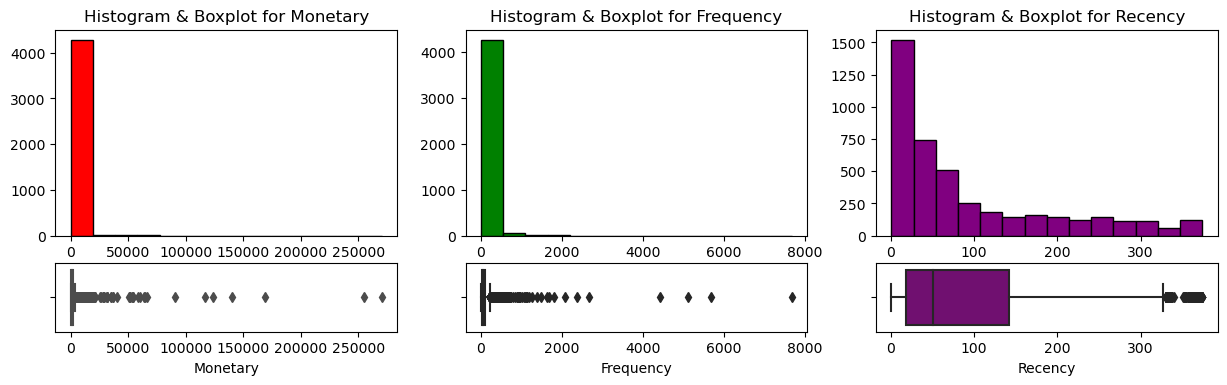

In [69]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, 
                         figsize = (15, 4), dpi = 100,
                         sharex = False, sharey = False,
                         gridspec_kw = {'height_ratios': [3, 1]}
                         )

# Monetary
axis[0, 0].hist(df_merge['Monetary'], bins = 'sturges', facecolor = 'red', edgecolor = 'black')
sns.boxplot(x = 'Monetary', data = df_merge,  color = 'red', ax = axis[1, 0])
axis[0, 0].set_title("Histogram & Boxplot for Monetary")

# Frequency
axis[0, 1].hist(df_merge['Frequency'], bins = 'sturges', facecolor = 'green', edgecolor = 'black')
sns.boxplot(x = 'Frequency', data = df_merge,  color = 'green', ax = axis[1, 1])
axis[0, 1].set_title("Histogram & Boxplot for Frequency")

# Recency
axis[0, 2].hist(df_merge['Recency'], bins = 'sturges', facecolor = 'purple', edgecolor = 'black')
sns.boxplot(x = 'Recency', data = df_merge,  color = 'purple', ax = axis[1, 2])
axis[0, 2].set_title("Histogram & Boxplot for Recency")

plt.show()

# it´s visible that Monetary and Frequency contain outliers, the plots are skewed

### REMOVE OUTLIERS IN M <5000 AND F<800

### Visual EDA 

C:\Users\admin\anaconda3\envs\DA_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


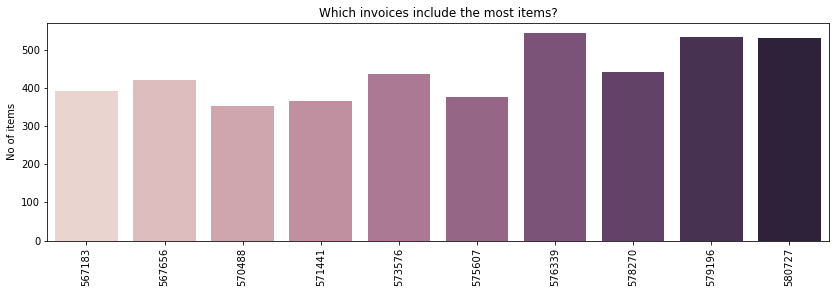

In [48]:
invoice_count = df_clean["InvoiceNo"].value_counts().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize =(14,4))
sns.barplot(invoice_count.index, invoice_count.values, palette = sns.cubehelix_palette(10))
plt.ylabel("No of items")
plt.title("Which invoices include the most items?");
plt.xticks(rotation = 90);

C:\Users\admin\anaconda3\envs\DA_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


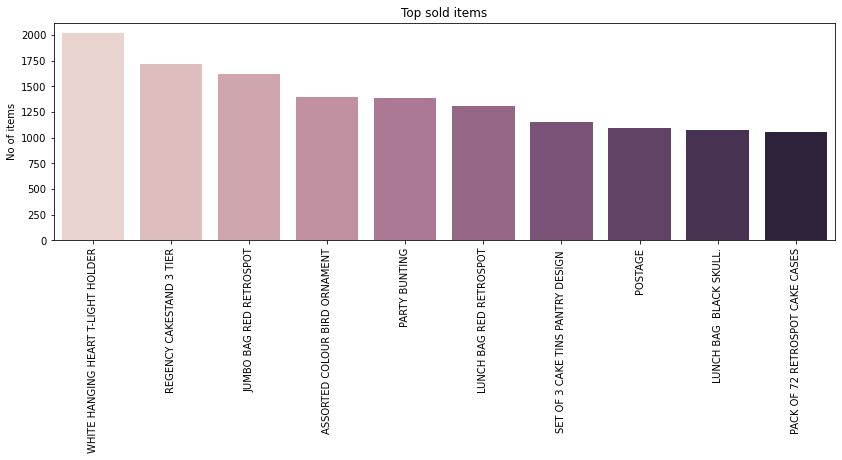

In [49]:
item_count = df_clean["Description"].value_counts().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize = (14,4))
sns.barplot(item_count.index, item_count.values, palette = sns.cubehelix_palette(10))
plt.ylabel("No of items")
plt.title("Top sold items");
plt.xticks(rotation = 90);

C:\Users\admin\anaconda3\envs\DA_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'France'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Germany'),
  Text(4, 0, 'Norway'),
  Text(5, 0, 'EIRE'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Spain'),
  Text(8, 0, 'Poland'),
  Text(9, 0, 'Portugal'),
  Text(10, 0, 'Italy'),
  Text(11, 0, 'Belgium'),
  Text(12, 0, 'Lithuania'),
  Text(13, 0, 'Japan'),
  Text(14, 0, 'Iceland'),
  Text(15, 0, 'Channel Islands'),
  Text(16, 0, 'Denmark'),
  Text(17, 0, 'Cyprus'),
  Text(18, 0, 'Sweden'),
  Text(19, 0, 'Finland'),
  Text(20, 0, 'Austria'),
  Text(21, 0, 'Greece'),
  Text(22, 0, 'Singapore'),
  Text(23, 0, 'Lebanon'),
  Text(24, 0, 'United Arab Emirates'),
  Text(25, 0, 'Israel'),
  Text(26, 0, 'Saudi Arabia'),
  Text(27, 0, 'Czech Republic'),
  Text(28, 0, 'Canada'),
  Text(29, 0, 'Unspecified'),
  Text(30, 0, 'Brazil'),


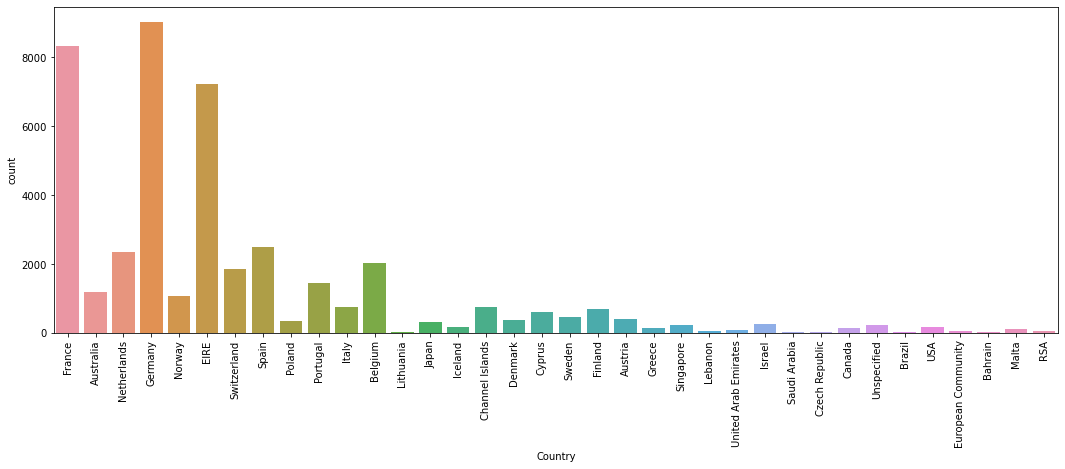

In [50]:
plt.figure(figsize=(18,6))
sns.countplot(df_clean[df_clean['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

<AxesSubplot:>

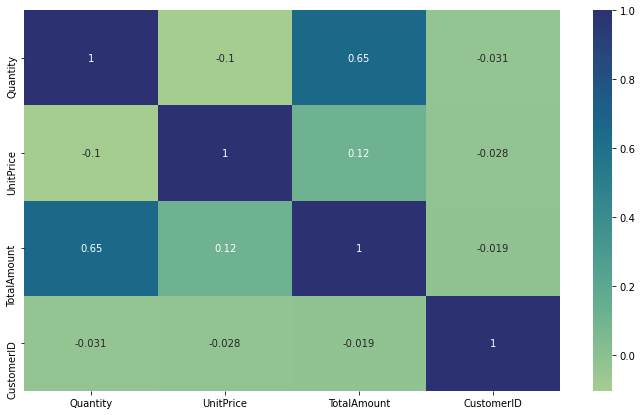

In [72]:
plt.figure(figsize=(12,7))

sns.heatmap(correlation,annot=True,cmap='crest')

# If two features correlate, that means they contain the same information. One should be removed for he modelling

In [71]:
correlation = df_clean.corr()
correlation

,Quantity,UnitPrice,TotalAmount,CustomerID
Quantity,1.000000,-0.104041,0.654345,-0.030731
UnitPrice,-0.104041,1.000000,0.115046,-0.028467
TotalAmount,0.654345,0.115046,1.000000,-0.018899
CustomerID,-0.030731,-0.028467,-0.018899,1.000000


C:\Users\admin\anaconda3\envs\DA_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'France'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Germany'),
  Text(4, 0, 'Norway'),
  Text(5, 0, 'EIRE'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Spain'),
  Text(8, 0, 'Poland'),
  Text(9, 0, 'Portugal'),
  Text(10, 0, 'Italy'),
  Text(11, 0, 'Belgium'),
  Text(12, 0, 'Lithuania'),
  Text(13, 0, 'Japan'),
  Text(14, 0, 'Iceland'),
  Text(15, 0, 'Channel Islands'),
  Text(16, 0, 'Denmark'),
  Text(17, 0, 'Cyprus'),
  Text(18, 0, 'Sweden'),
  Text(19, 0, 'Finland'),
  Text(20, 0, 'Austria'),
  Text(21, 0, 'Greece'),
  Text(22, 0, 'Singapore'),
  Text(23, 0, 'Lebanon'),
  Text(24, 0, 'United Arab Emirates'),
  Text(25, 0, 'Israel'),
  Text(26, 0, 'Saudi Arabia'),
  Text(27, 0, 'Czech Republic'),
  Text(28, 0, 'Canada'),
  Text(29, 0, 'Unspecified'),
  Text(30, 0, 'Brazil'),


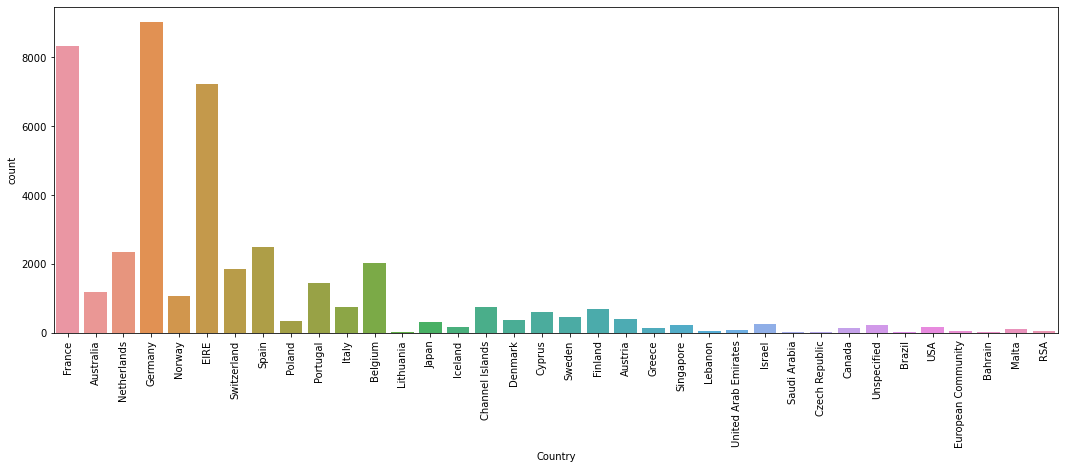

In [73]:


plt.figure(figsize=(18,6))
sns.countplot(df_clean[df_clean['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)



##### Data Preprocessing 

#### Save data to excel

In [ ]:
#df_clean.to_excel('df_retail.xlsx', index=False)

In [ ]:
#df_purchases.to_excel('df_purchases.xlsx', index=False)